## **Trash Sorting Classification using EfficientNetV2 Small**

### **Project Setup**

In [ ]:
# Download necessary libraries
!pip install tensorflow numpy pandas matplotlib seaborn scikit-learn pillow opencv-python tqdm

In [ ]:
# Import libraries
import os
from pathlib import Path
from collections import Counter
import shutil

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models

from tensorflow.keras.applications import EfficientNetV2S # This is for EfficientNetV2
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as effv2_preprocess # This is for EfficientNetV2

from tensorflow.keras.applications import EfficientNetB0 # This is for EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input # This is for EfficientNetB0

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing import image

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import kagglehub

### **Data Loading**

**Download Dataset from Kaggle**

In [ ]:
# Download latest version of data
path = kagglehub.dataset_download("mostafaabla/garbage-classification")
print("Path to dataset files:", path)

Using Colab cache for faster access to the 'garbage-classification' dataset.
Path to dataset files: /kaggle/input/garbage-classification


In [ ]:
# Check the directories inside the path
print(os.listdir(path))

['garbage_classification']


**Setup Configuration**

In [ ]:
# Define the dataset directory
DATA_DIR = "/kaggle/input/garbage-classification/garbage_classification"

# Setup up configuration for global constant variables
IMG_SIZE = 224
BATCH_SIZE = 32
SEED = 42

EPOCHS_BASELINE = 10
EPOCHS_STAGE1 = 10   # EfficientNet frozen (for generic layer)
EPOCHS_STAGE2 = 10   # EfficientNet fine-tune

**Collect Image Paths and Labels**

In [ ]:
# Define data path
data_path = Path(DATA_DIR)

# Sort class names from the main directory
class_names = sorted([d.name for d in data_path.iterdir() if d.is_dir()])

# Create class index
class_to_idx = {name: i for i, name in enumerate(class_names)}
num_classes = len(class_names)

print("Classes:", class_names)
print("Num classes:", num_classes)

Classes: ['battery', 'biological', 'brown-glass', 'cardboard', 'clothes', 'green-glass', 'metal', 'paper', 'plastic', 'shoes', 'trash', 'white-glass']
Num classes: 12


In [ ]:
# Define path and labels
paths = []
labels = []

for class_name in class_names:
    class_dir = data_path / class_name

    for img_path in class_dir.glob("*.*"):
        paths.append(str(img_path))
        labels.append(class_to_idx[class_name])

paths = np.array(paths)
labels = np.array(labels)

print("Total images: ", len(paths))

Total images:  15515


**Quck Image Visualization**

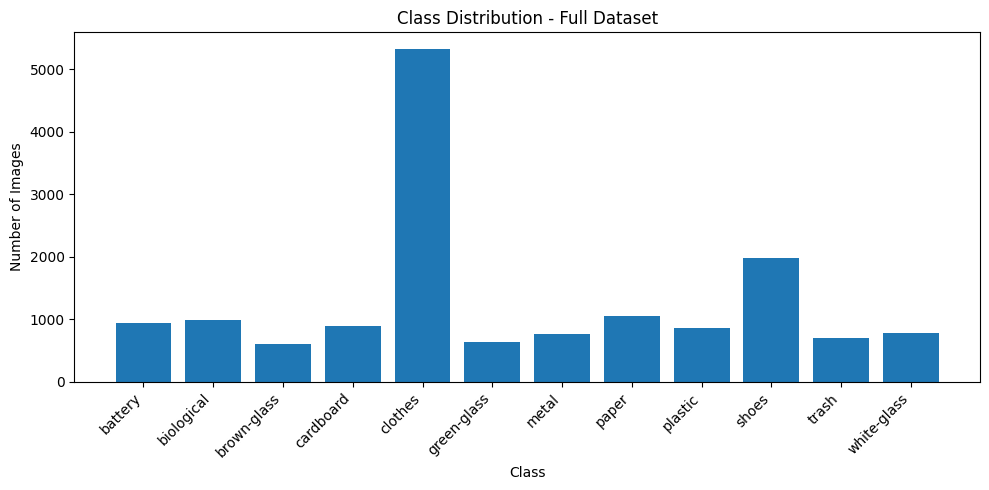

In [ ]:
# Class distribution
counts = Counter(labels)
counts_list = [counts[i] for i in range(num_classes)]

plt.figure(figsize=(10, 5))
plt.bar(class_names, counts_list)
plt.xticks(rotation=45, ha="right")
plt.title("Class Distribution - Full Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.tight_layout()
plt.show()

In [ ]:
# Visualize the classes images
n_samples_per_class = 3

n_cols = n_samples_per_class
n_rows = num_classes

plt.figure(figsize=(3 * n_cols, 2.5 * n_rows))

for row, cname in enumerate(class_names):
    # Get indices for this class
    class_idx = class_to_idx[cname]
    indices = [i for i, lbl in enumerate(labels) if lbl == class_idx]
    # Pick random samples
    sample_indices = random.sample(indices, min(n_samples_per_class, len(indices)))

    for col, idx in enumerate(sample_indices):
        img_path = paths[idx]
        img = Image.open(img_path).convert("RGB")

        ax = plt.subplot(n_rows, n_cols, row * n_cols + col + 1)
        ax.imshow(img)
        ax.set_title(cname)
        ax.axis("off")
        if col == 0:
            ax.set_ylabel(cname, rotation=0, labelpad=40, fontsize=10, va="center")

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

### **Data Preparation**

**Data Splitting**

In [ ]:
# Split the dataset into train/val/test - 70/15/15
paths_train, paths_temp, labels_train, labels_temp = train_test_split(
    paths,
    labels,
    test_size=0.3,
    stratify=labels,
    random_state=SEED
)

# Split on temp (val/test)
paths_val, paths_test, labels_val, labels_test = train_test_split(
    paths_temp,
    labels_temp,
    test_size=0.5,
    stratify=labels_temp,
    random_state=SEED
)

print("Train:", len(paths_train))
print("Val:", len(paths_val))
print("Test:", len(paths_test))

Train: 10860
Val: 2327
Test: 2328


**Class Weights**

In [ ]:
# Compute class weights for training set only
class_weights_array = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(labels_train),
    y=labels_train
)

class_weight = {i: w for i, w in enumerate(class_weights_array)}
print("Class weights:", class_weight)

Class weights: {0: np.float64(1.3691376701966718), 1: np.float64(1.3134978229317853), 2: np.float64(2.1294117647058823), 3: np.float64(1.4503205128205128), 4: np.float64(0.24282264555943117), 5: np.float64(2.0568181818181817), 6: np.float64(1.6821561338289963), 7: np.float64(1.2312925170068028), 8: np.float64(1.4933993399339933), 9: np.float64(0.6539017341040463), 10: np.float64(1.8545081967213115), 11: np.float64(1.6666666666666667)}


**Build TensforFlow Dataset**

In [ ]:
# Set autotune for optimal performance setting for data pipelines
AUTOTUNE = tf.data.AUTOTUNE

# Define a function to decode and resize images
def decode_and_resize(path, label):

    # Read file path
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img = tf.cast(img, tf.float32)

    return img, label


# Define a function to make the dataset
def make_dataset(paths, labels, shuffle=False):

    # Create dataset
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)

    # Decode and resize the image
    ds = ds.map(decode_and_resize, num_parallel_calls=AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return ds

In [ ]:
# Create train, test, and val dataset
train_ds = make_dataset(paths_train, labels_train, shuffle=True)
val_ds   = make_dataset(paths_val,   labels_val,   shuffle=False)
test_ds  = make_dataset(paths_test,  labels_test,  shuffle=False)

**Data Augmentation**

In [ ]:
# Create data augmentation pipeline
data_augmentation = tf.keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
      layers.RandomZoom(height_factor=(-0.2, -0.3), interpolation = 'bilinear'),
      layers.RandomContrast(factor=0.1),
      layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    ],
    name = "data_augmentation",
)

### **Baseline CNN**

In [ ]:
# Define a model architecture
def create_baseline_cnn(input_shape=(IMG_SIZE, IMG_SIZE, 3), num_classes=num_classes):

    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Data augmentation
    x = data_augmentation(inputs)             # augmentation
    x = layers.Rescaling(1./255)(x)           # normalize to [0,1]

    # Convolutional layers
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D()(x)

    # Flatten layer
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # Model settings
    model = models.Model(inputs, outputs, name="baseline_cnn")
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy'],
    )
    return model

**Train Baseline CNN**

In [ ]:
# Start training on the baseline cnn
baseline_model = create_baseline_cnn()
baseline_model.summary()

Model: "baseline_cnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    12,845,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 12)             │         1,548 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,939,980 (49.36 MB)

 Trainable params: 12,939,980 (49.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define callbacks and earlystopping for overfitting
callbacks_baseline = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("baseline_cnn_best.keras", monitor="val_loss", save_best_only=True),
]

# Fit the training and validation set
history_baseline = baseline_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_BASELINE,
    class_weight=class_weight,
    callbacks=callbacks_baseline,
)

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 83s 222ms/step - accuracy: 0.2788 - loss: 2.1927 - val_accuracy: 0.4422 - val_loss: 1.5658
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 28s 81ms/step - accuracy: 0.4256 - loss: 1.6645 - val_accuracy: 0.4688 - val_loss: 1.5532
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 26s 76ms/step - accuracy: 0.4850 - loss: 1.5281 - val_accuracy: 0.5067 - val_loss: 1.4773
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 25s 75ms/step - accuracy: 0.4901 - loss: 1.4772 - val_accuracy: 0.4994 - val_loss: 1.5486
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.5340 - loss: 1.3939 - val_accuracy: 0.5385 - val_loss: 1.3760
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.5239 - loss: 1.3737 - val_accuracy: 0.5801 - val_loss: 1.2708
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 25s 74ms/step - accuracy: 0.5477 - loss: 1.3210 - val_accuracy: 0.5471 - val_loss: 1.3705
Epoch 8/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 24s 71ms/step - accuracy: 0.5701 - loss: 1.2950 -

**Test Evaluation**

In [ ]:
# Get the accuracy score
test_loss_base, test_acc_base = baseline_model.evaluate(test_ds)
print(f"Baseline CNN - Test Loss: {test_loss_base:.4f}, Test Acc: {test_acc_base:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 12s 165ms/step - accuracy: 0.6072 - loss: 1.1935
Baseline CNN - Test Loss: 1.1704, Test Acc: 0.6100


### **EfficientNetV2 Transfer Learning**

**Build Frozen Base**

In [ ]:
# Load pretrained EfficientNetV2-S backbone
base_model = EfficientNetV2S(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
)

# Freeze the parameters for stage 1
base_model.trainable = False

# Define the input layers
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

# Apply data augmentation
x = data_augmentation(inputs)

# Apply EfficientNet normalization
x = effv2_preprocess(x)
x = base_model(x, training=False)

# Apply global average pooling for flatenning
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)

# Define the model
effv2_model = models.Model(inputs, outputs, name="efficientnet_v2s_transfer")
effv2_model.summary()

82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "efficientnet_v2s_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,346,732 (77.62 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

In [ ]:
# Train the first stage
effv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

# Define callbacks and earlystopping for overfitting
callbacks_stage1 = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("effv2s_stage1_best.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

# Fit the training and validation set
history_stage1 = effv2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1,
    class_weight=class_weight,
    callbacks=callbacks_stage1,
)

Epoch 1/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 102s 233ms/step - accuracy: 0.3569 - loss: 2.2330 - val_accuracy: 0.8264 - val_loss: 1.1992 - learning_rate: 1.0000e-04
Epoch 2/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - accuracy: 0.7922 - loss: 1.3350 - val_accuracy: 0.8724 - val_loss: 0.7530 - learning_rate: 1.0000e-04
Epoch 3/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 189ms/step - accuracy: 0.8556 - loss: 0.9587 - val_accuracy: 0.8896 - val_loss: 0.5715 - learning_rate: 1.0000e-04
Epoch 4/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 189ms/step - accuracy: 0.8642 - loss: 0.7715 - val_accuracy: 0.8990 - val_loss: 0.4782 - learning_rate: 1.0000e-04
Epoch 5/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - accuracy: 0.8744 - loss: 0.6839 - val_accuracy: 0.9042 - val_loss: 0.4192 - learning_rate: 1.0000e-04
Epoch 6/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 64s 188ms/step - accuracy: 0.8851 - loss: 0.6087 - val_accuracy: 0.9067 - val_loss: 0.3799 - learning_rate: 1.0000e-04
Epoch 7/10
340/340 ━━━━━━━━━━━━━━━━━━━━ 82s 1

In [ ]:
# Final eff model
effv2_model.summary()

Model: "efficientnet_v2s_transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-s (Functional)   │ (None, 7, 7, 1280)     │    20,331,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │        15,372 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,377,478 (77.73 MB)

 Trainable params: 15,372 (60.05 KB)

 Non-trainable params: 20,331,360 (77.56 MB)

 Optimizer params: 30,746 (120.11 KB)

**Unfreeze Top Layers**

In [ ]:
# Set the base model to trainable true
base_model.trainable = True

# Train on the last 20 layers
fine_tune_at = len(base_model.layers) - 20

# Set the lat 20 layers to be trainable
for i, layer in enumerate(base_model.layers):
    if i < fine_tune_at:
        layer.trainable = False

print("Total layers in base_model:", len(base_model.layers))
print("Trainable layers in base_model:", sum([1 for l in base_model.layers if l.trainable]))

Total layers in base_model: 513
Trainable layers in base_model: 20


In [ ]:
# Train the model with smaller learning rate
effv2_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

# Define callbacks for stage 2
callbacks_stage2 = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ModelCheckpoint("effv2s_stage2_best.keras", monitor="val_loss", save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6),
]

history_stage2 = effv2_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS_STAGE1 + EPOCHS_STAGE2,
    initial_epoch=history_stage1.epoch[-1] + 1,
    class_weight=class_weight,
    callbacks=callbacks_stage2,
)

Epoch 11/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 96s 214ms/step - accuracy: 0.8728 - loss: 0.5013 - val_accuracy: 0.9141 - val_loss: 0.3502 - learning_rate: 1.0000e-05
Epoch 12/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 76s 200ms/step - accuracy: 0.8861 - loss: 0.4471 - val_accuracy: 0.9183 - val_loss: 0.3224 - learning_rate: 1.0000e-05
Epoch 13/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.8923 - loss: 0.4332 - val_accuracy: 0.9252 - val_loss: 0.2896 - learning_rate: 1.0000e-05
Epoch 14/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.9000 - loss: 0.4021 - val_accuracy: 0.9261 - val_loss: 0.2837 - learning_rate: 1.0000e-05
Epoch 15/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 68s 199ms/step - accuracy: 0.9027 - loss: 0.3967 - val_accuracy: 0.9317 - val_loss: 0.2724 - learning_rate: 1.0000e-05
Epoch 16/20
340/340 ━━━━━━━━━━━━━━━━━━━━ 67s 198ms/step - accuracy: 0.9074 - loss: 0.3954 - val_accuracy: 0.9347 - val_loss: 0.2597 - learning_rate: 1.0000e-05
Epoch 17/20
340/340 ━━━━━━━━━━━━━━━━━━━━

**Evaluation**

In [ ]:
test_loss_eff, test_acc_eff = effv2_model.evaluate(test_ds)
print(f"EfficientNet - Test Loss: {test_loss_eff:.4f}, Test Acc: {test_acc_eff:.4f}")
print(f"Baseline CNN  - Test Acc: {test_acc_base:.4f}")
print(f"EfficientNet   - Test Acc: {test_acc_eff:.4f}")

73/73 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9279 - loss: 0.2454
EfficientNet - Test Loss: 0.2372, Test Acc: 0.9377
Baseline CNN  - Test Acc: 0.6100
EfficientNet   - Test Acc: 0.9377


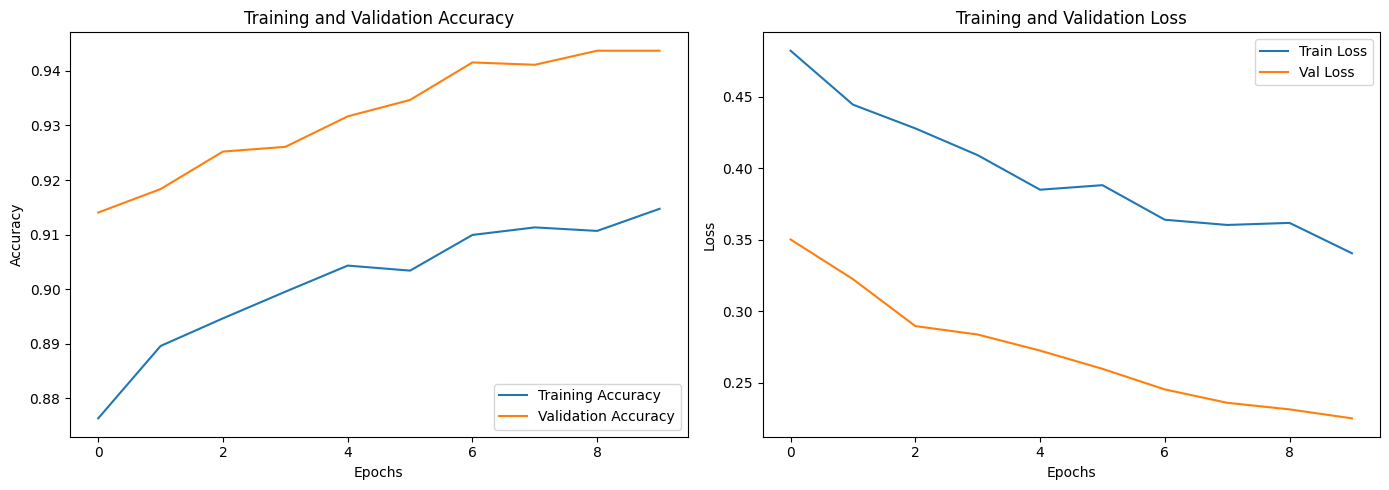

In [ ]:
# Plot the stage 2 model history line
acc = history_stage2.history.get("accuracy", [])
val_acc = history_stage2.history.get("val_accuracy", [])
loss = history_stage2.history.get("loss", [])
val_loss = history_stage2.history.get("val_loss", [])

epochs_range = range(len(acc))

plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [ ]:
# Get the classification report
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = effv2_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("Classification report (EfficientNet on test set):\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
cm

Classification report (EfficientNet on test set):

              precision    recall  f1-score   support

     battery       0.94      0.94      0.94       142
  biological       0.98      0.97      0.98       148
 brown-glass       0.93      0.85      0.89        91
   cardboard       0.90      0.91      0.91       134
     clothes       0.99      0.97      0.98       799
 green-glass       0.84      0.98      0.91        94
       metal       0.85      0.90      0.87       115
       paper       0.89      0.86      0.87       158
     plastic       0.86      0.80      0.83       130
       shoes       0.96      0.99      0.98       297
       trash       0.90      0.95      0.93       104
 white-glass       0.88      0.85      0.86       116

    accuracy                           0.94      2328
   macro avg       0.91      0.92      0.91      2328
weighted avg       0.94      0.94      0.94      2328



array([[134,   0,   0,   2,   0,   0,   5,   0,   0,   0,   1,   0],
       [  0, 144,   0,   0,   0,   0,   0,   3,   1,   0,   0,   0],
       [  0,   0,  77,   1,   0,   8,   2,   0,   0,   0,   0,   3],
       [  1,   0,   0, 122,   0,   0,   1,   8,   1,   0,   1,   0],
       [  1,   0,   0,   1, 777,   0,   1,   2,   0,  12,   5,   0],
       [  0,   0,   0,   0,   0,  92,   0,   0,   1,   0,   1,   0],
       [  3,   0,   1,   0,   0,   0, 104,   2,   3,   0,   0,   2],
       [  4,   1,   0,   7,   3,   0,   2, 136,   2,   1,   2,   0],
       [  0,   1,   2,   1,   0,   6,   5,   2, 104,   0,   1,   8],
       [  0,   0,   0,   1,   1,   0,   0,   0,   0, 295,   0,   0],
       [  0,   0,   1,   0,   2,   0,   1,   0,   0,   0,  99,   1],
       [  0,   1,   2,   0,   0,   3,   2,   0,   9,   0,   0,  99]])

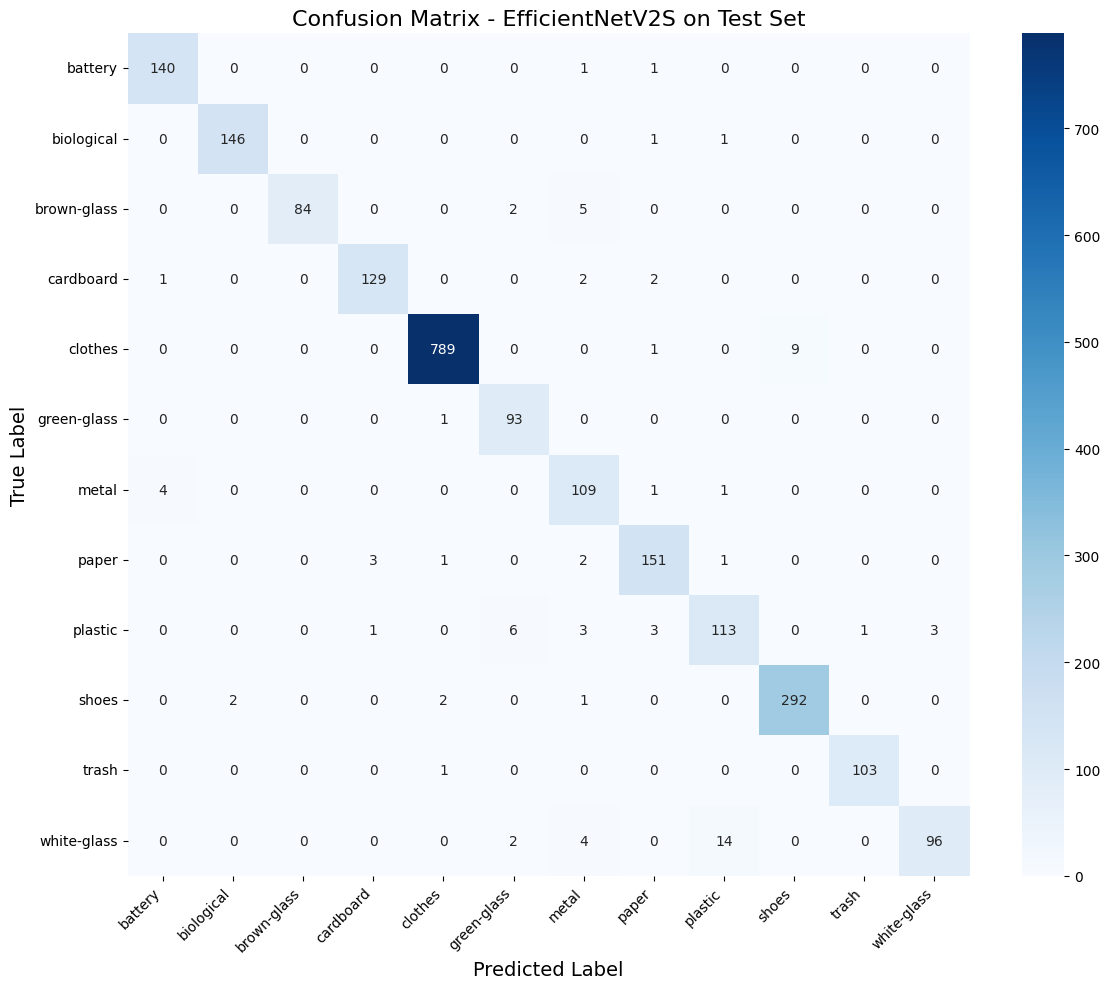

In [ ]:
# Plot the confustion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)

plt.title("Confusion Matrix - EfficientNetV2S on Test Set", fontsize=16)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()

**Predict Sample Image**

In [ ]:
# Define a function to predict new test sample
def show_prediction_sample(idx, model, paths, labels, class_names):

    img_path = paths[idx]
    true_label = labels[idx]

    # Load and preprocess image the same way as training
    img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img_array = image.img_to_array(img)

    # Save original image for visualization
    img_display = img_array.astype("uint8")

    # Preprocess for model prediction
    img_array = tf.expand_dims(img_array, 0)   # batch dimension
    img_array = tf.cast(img_array, tf.float32)

    # EfficientNet requires preprocess_input
    img_preprocessed = preprocess_input(img_array)

    # Predict
    preds = model.predict(img_preprocessed, verbose=0)
    pred_class_idx = np.argmax(preds)
    pred_class_name = class_names[pred_class_idx]

    # Plot the image
    plt.figure(figsize=(5, 5))
    plt.imshow(img_display)
    plt.axis("off")

    # Title with true + predicted
    plt.title(
        f"True: {class_names[true_label]}\nPredicted: {pred_class_name}",
        fontsize=12,
        color="green" if pred_class_idx == true_label else "red",
    )
    plt.show()

    return pred_class_name

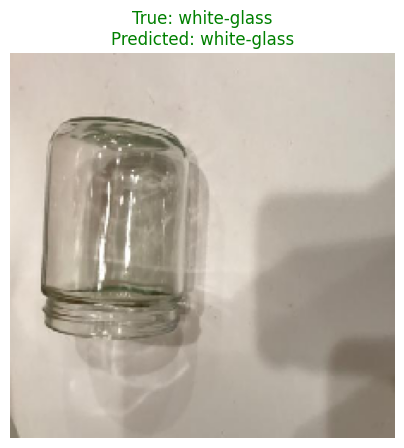

'white-glass'

In [ ]:
# Randomly select a sample
i = random.randint(0, len(paths_test)-1)
show_prediction_sample(i, effv2_model, paths_test, labels_test, class_names)

**Save Model Checkpoints**

In [ ]:
# Define the base directory
BASE_DIR = "/content/drive/MyDrive/Machine Learning Final Project"

# Copy from colab to drive
shutil.copy("/content/baseline_cnn_best.keras", BASE_DIR)
shutil.copy("/content/effv2s_stage1_best.keras", BASE_DIR)
shutil.copy("/content/effv2s_stage2_best.keras", BASE_DIR)

'/content/drive/MyDrive/Machine Learning Final Project/effv2s_stage2_best.keras'

In [ ]:
# Save the final model
best_model = tf.keras.models.load_model("/content/effv2s_stage2_best.keras")
best_model.save("/content/drive/MyDrive/Machine Learning Final Project/garbage_effnetv2_final.keras")